# Model 1 for fitted distributions

This notebook generates a monotonic decreasing fit to an observed age distribution and simulates that fitted distribution using model 1 (where agents survive according to an age-specific surivival probability). This method is suitable for age distributions where it is not appropriate to directly apply either model 1 or model 2.

## Import packages

In [1]:
#Load in required libraries
import pandas as pd
import numpy as np
import os, warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import wasserstein_distance

warnings.simplefilter("ignore")

## Define necesssary functions

In [2]:
def p_n_min_getter(target_dist): # Calculate minimum possible value of p_n
    
    p_n_min = 1 - (target_dist[(n_groups-1)-1]/target_dist[n_groups-1]) 
    
    return p_n_min

def analytic_solver(target_dist, p_n): # Calculate surivival probabilities for given target_dist and p_n
    
    survival_probs_analytical = np.zeros(n_groups)
    
    for group in range(n_groups-2):
        survival_probs_analytical[group] = target_dist[group+1]/target_dist[group]
        
    survival_probs_analytical[(n_groups-1)-1] = (1-p_n)*(target_dist[(n_groups-1)]/target_dist[(n_groups-1)-1])
    
    survival_probs_analytical[-1]=p_n
    
    return survival_probs_analytical
    
def obj_func(survive_probas): # Run simulation
    
    # survive_probas = survive_probas_sol/survive_probas_sol.max()
    ages = np.random.randint(0, n_groups, size=pop_size).astype(int)
    ages_history = np.zeros((n_groups, max_itera))
    
    for itera in range(max_itera):
        
        trials = np.random.rand(pop_size)
        survival_probabilities = survive_probas[ages]
        survivals = trials <= survival_probabilities
        deaths = trials > survival_probabilities
        ages[survivals] += 1
        ages[ages==n_groups] -= 1
        ages[deaths] = 0
        
        uages, freqs = np.unique(ages, return_counts=True)
        ages_history[uages, itera] = freqs
        

        if itera == max_itera-1:
            
            plt.figure(0, figsize=(6,4))
            
            for i in range(n_groups):
                plt.plot(ages_history[i,:], color = palette[i])
            plt.xlabel("Timestep")
            plt.ylabel("# of individuals in age class")
            plt.xlim([0,max_itera-1])
            plt.title(f"Population: {df.iloc[numselect,3]}")
            
            plt.tight_layout()
            plt.savefig(f'{home}data/results/timeseries_{df.iloc[numselect,3]}_model1_fitted.png', bbox_inches="tight", dpi=500)
            plt.show()

    # ages_final = np.zeros(n_groups)
    # uages, freqs = np.unique(ages, return_counts=True)
    # ages_final[uages] = freqs
    ages_final = ages_history[:,-100::].mean(axis=1)
    # ages_dist = np.cumsum(ages_final/ages_final.sum())
    ages_dist_noncum = ages_final/ages_final.sum()
    
    return (np.mean(np.abs(ages_dist_noncum - target_dist_noncum)), ages_dist_noncum)

def decay_fcn(x, A, B, C): # Define functional form for fitted distribution
    
    y = A*np.ones(len(x))
    y[k:] = A*np.exp(-B*((x[k:] - x[k])**C))
    
    return y

## Read in necessary data

In [3]:
# Set working directory
home =  os.getcwd()[:-4]

# Read in age distribution data for distributions which are not monotonic decreasing
df_full = pd.read_csv(f'{home}data/required/agedists_countries2019_other.csv')

# Read in list of countries that model 2 was not successful in simulating with the below values of algthresh and maxsteps (please contact repository owner for details on how this file was generated)
algthresh = 1e-4 # Set the threshold for stoppping the fitting algorithm - from model 2, leave as-is
maxsteps = 250 # Maximum number of steps to run of the fitting algorithm - from model 2, leave as-is
df_failed = pd.read_csv(f'{home}data/required/agedists_other_model2failed_thresh{algthresh}_maxsteps{maxsteps}.csv')

# Keep only age distributions for countries where model 2 failed
df = df_full[df_full['Region, subregion, country or area *'].isin(df_failed['0'])]

## Select age distribution to be fit and simulated

In [4]:
numselect=77 # Select index of the age distribution you want to simulate (numselect=77 returns the UK's age distribution)
target_dist_full = df.iloc[numselect, -22:-1]
target_dist = target_dist_full[target_dist_full>0].copy() #Drop all age classes containing zero individuals (can be absorbed into a neighbouring class)
n_groups = len(target_dist) # Set number of groups to match the number of age classes in the data
target_dist_noncum = target_dist/target_dist.sum() # Calculate age distribution from counts of individuals in eage age class
target_dist_cum = np.cumsum(target_dist/target_dist.sum()) # Calcualte cumulative age distribution from counts of individuals in each age class

# Generate array of dummy data matching the length of our target distribution
xdat = np.asarray(np.arange(0, len(target_dist_cum)) + 1)
ydat = np.asarray(target_dist_cum)

## Generate fit

In [5]:
# Initialise values for the fitting process
best_wass = 100 # Large dummy value, leave as is
best_k = -1 # Dummy value, leave as is
best_parms = []

for k_val in range(n_groups): # Determine k-value (and associated A,B,C) that give the lowest value of the Wasserstein metric

    k = k_val

    # Fit curve
    ydat = np.asarray(target_dist/target_dist.sum())
    parameters, covariance = curve_fit(decay_fcn, xdat, ydat)

    fit_A = parameters[0]
    fit_B = parameters[1]
    fit_C = parameters[2]

    fit_y = decay_fcn(xdat, fit_A, fit_B, fit_C)

    wass_dist = wasserstein_distance(target_dist/target_dist.sum(), fit_y)

    if (wass_dist < best_wass) & (abs(fit_y.sum()-1) <= 0.01):
        best_wass = wass_dist
        best_k = k
        best_parms = parameters

# Set parameters for simulation based on the best fit obtained above
fit_A = best_parms[0]
fit_B = best_parms[1]
fit_C = best_parms[2]
k = best_k
fit_y = decay_fcn(xdat, fit_A, fit_B, fit_C)

## Set simulation parameters

In [10]:
pop_size = 10000 # Set number of agents within a simulation
max_itera = 350 # Set total number of timesteps in simulation

target_dist_noncum_fitted = fit_y # Use the fitted distribution as the target distribution to compare our simulated distribution to

# generate colour palette for timeseries plot based on n_groups
palette = sns.color_palette("flare", n_groups)

## Find minimum p_n value
p_n_min = p_n_min_getter(target_dist_noncum_fitted)

# print(f"Minimum possible p_n value: {p_n_min_getter(target_dist)}")

if p_n_min <0:
    p_n_min = 0 #If min p_n <0 set =0 since probabilties cannot be <0

# Generate a random p_n value no smaller than our minimum possible p_n value
p_n = 0.26 #np.random.rand()*(1-p_n_min) + p_n_min

# Generate the corresponding p_i values for i=1,...,n-1
analytical_survival_probs = analytic_solver(target_dist_noncum_fitted, p_n)

## Run a simulation

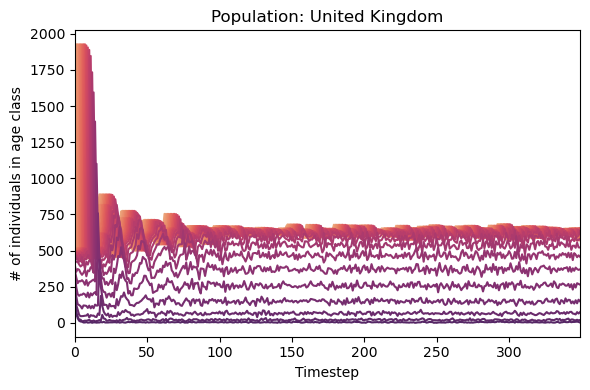

In [11]:
# Run a simulation with the previously calculated survival probabilities
sim_output = obj_func(analytical_survival_probs)
numerical_dist_noncum = sim_output[1]

## Plot results

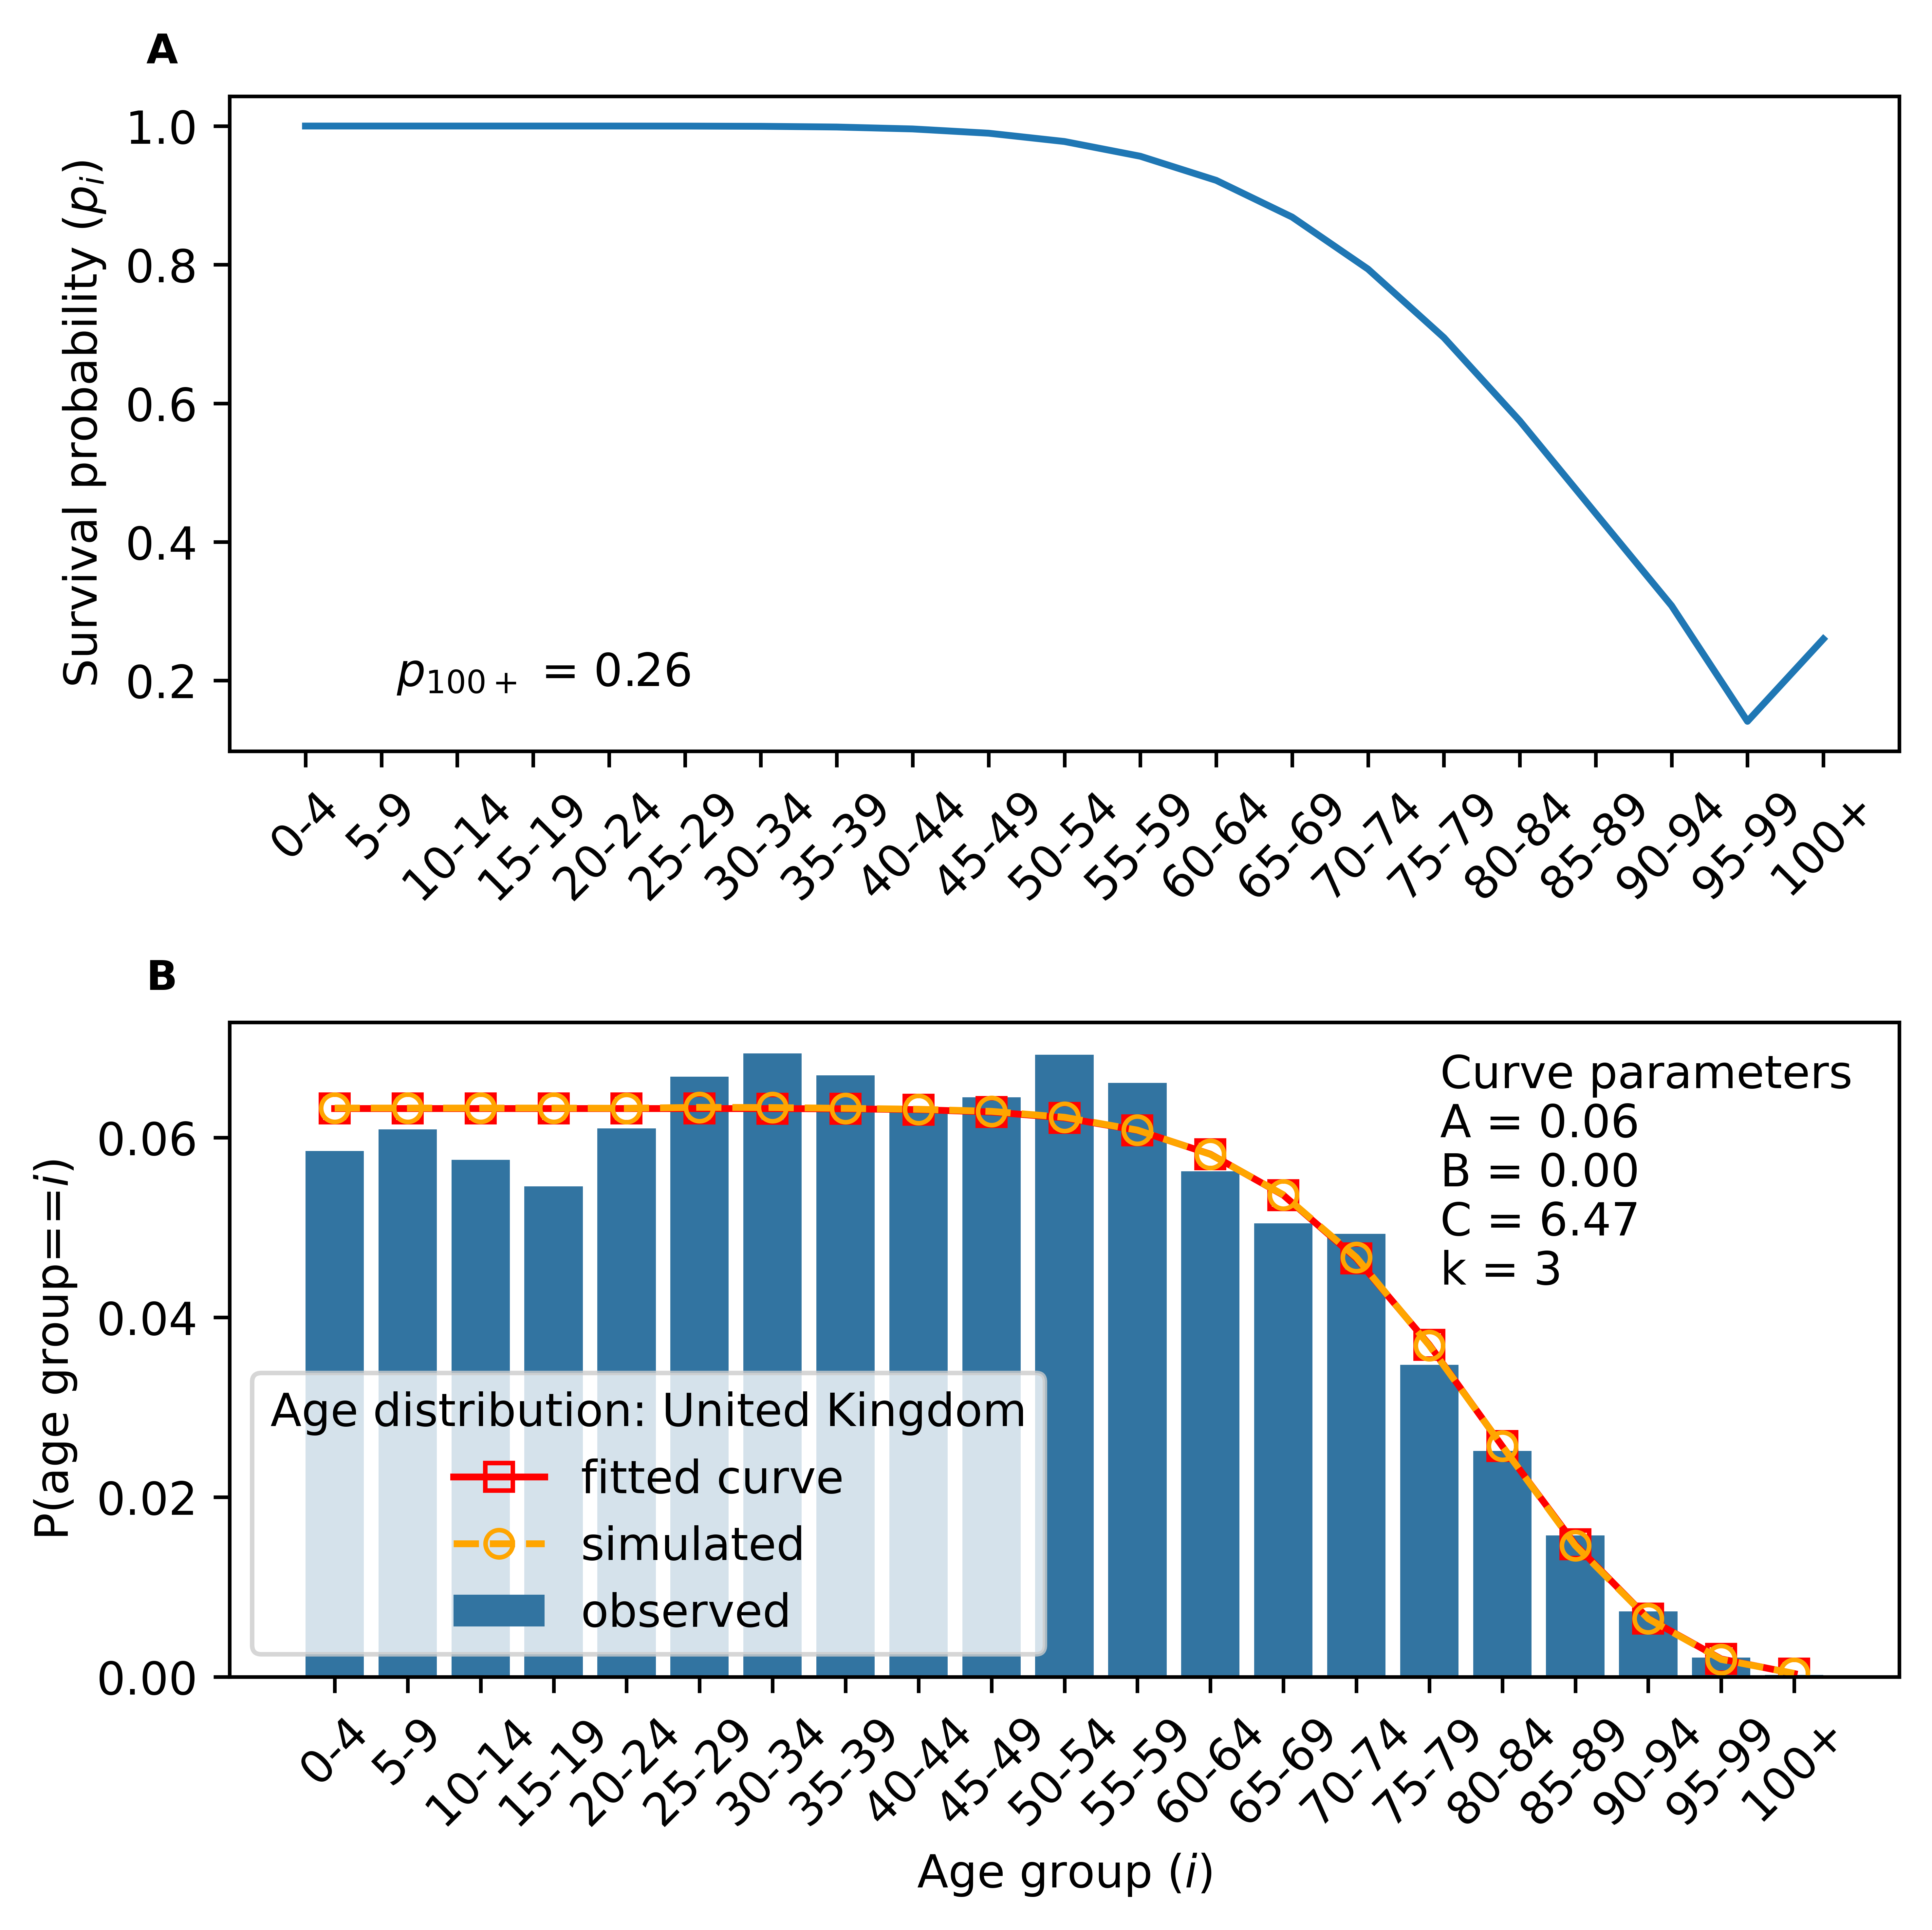

Wasserstein metric value: 0.00265836143509505


In [12]:
# Plotting parameters
cap = [ "A", "B", "C"]

subcap_x = -0.05
subcap_y = 1.05

label_x = 0.725
label_y = 0.9
label_incr = 0.075

dpi_val = 1000

# Generate plot of calculated survivial probabilities and resulting fit to the observed and fitted age distributions
plt.figure(0, figsize=(6000/dpi_val, 6000/dpi_val), dpi=dpi_val)

plt.subplot(211)
ax1=sns.lineplot(x=target_dist.index, y = analytical_survival_probs)
ax1.text(subcap_x, subcap_y, cap[0], transform=ax1.transAxes, size=9, weight='bold')
ax1.text(0.1, 0.1, r"$p_{100+}$ = %.2f" % p_n, transform=ax1.transAxes)
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel(r"Survival probability ($p_i$)")

plt.subplot(212)
ax2=sns.barplot(x=target_dist.index, y=target_dist_noncum, label = "observed", color = '#1f77b4')
ax2.text(subcap_x, subcap_y, cap[1], transform=ax2.transAxes, size=9, weight='bold') 
ax2.text(label_x, label_y, "Curve parameters", transform=ax2.transAxes)  
ax2.text(label_x, label_y - label_incr, "A = %.2f" % fit_A, transform=ax2.transAxes) 
ax2.text(label_x, label_y - 2*label_incr, "B = %.2f" % fit_B, transform=ax2.transAxes) 
ax2.text(label_x, label_y - 3*label_incr, "C = %.2f" % fit_C, transform=ax2.transAxes) 
ax2.text(label_x, label_y - 4*label_incr, "k = %.0f" % k, transform=ax2.transAxes) 
plt.plot(xdat-1, fit_y, 's-', color="red", markerfacecolor='none', label='fitted curve')
plt.plot(numerical_dist_noncum, "o--", color="orange", markerfacecolor='none', label = "simulated")
plt.legend(title=f"Age distribution: {df.iloc[numselect,3]}", loc = 'lower left')
plt.xticks(rotation=45)
plt.xlabel(r"Age group ($i$)")
plt.ylabel(r"P(age group==$i$)")

plt.tight_layout()
plt.savefig(f'{home}data/results/agedist_{df.iloc[numselect,3]}_model1_fitted.png', bbox_inches="tight")
plt.show()

wass_dist = wasserstein_distance(target_dist_noncum, fit_y)
print(f'Wasserstein metric value: {wass_dist}')

## Store parametrisation

Surrival probabilities will be stored in ascending age group order.

In [52]:
pd.DataFrame(analytical_survival_probs).to_csv(f'{home}data/results/survivalprobs_{df.iloc[numselect,3]}_model1_fitted.csv', index=False, header=False)